# Fit BAO peak from input correlation function

In [1]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from cosmoprimo import *

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import split_density, compute_densitySplit_CCF
from densitysplit.pk_model import *
from densitysplit.utils import *
from densitysplit.corr_func import *

# To activate logging
setup_logging()

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
catalog_name = 'AbacusSummit_1Gpc_z1.175'
bias = 1.8

#catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

In [4]:
z = catalog.redshift

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()
f = bg.Omega_m(z)**0.55

## Load correlation function poles

In [5]:
ells = [0]
nells = len(ells)
nsplits = 2

In [6]:
s, xiell_split, cov_split = np.load(output_dir+catalog.name+'_1000_mocks_densitySplit_gg_CCF_monopole_cov.npy', allow_pickle=True)
std_split = np.array_split(np.array(np.array_split(np.diag(cov_split)**0.5, nells)), nsplits, axis=1)

### DS2 only

In [7]:
split = 1

xiell = xiell_split[split]
cov = extract_subcovmatrix(s, cov_split, ells, nsplits, split_extract=split)
std = np.array_split(np.diag(cov)**0.5, nells)

In [8]:
mocks_results = np.load(output_dir+catalog.name+'_1000_mocks_2PCF.npy', allow_pickle=True)
ells = [0]
nells = len(ells)

xiell, cov = get_poles(mocks_results, ells)
std = np.array_split(np.diag(cov)**0.5, nells)

## Set power spectrum model

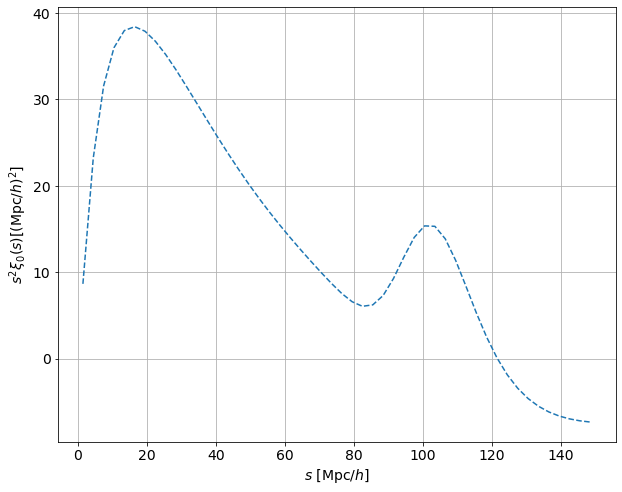

In [9]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
default_params = {'f': 0., 'b': 1.8, 'alpha_par': 1., 'alpha_perp': 1., 'sigma_par': 5., 'sigma_perp': 5., 'sigma_s': 0.}
pk_model.set_default_params(**default_params)
pk_model.plot_model()

## Fit model to data

In [10]:
# Remove small scales (linear model not valid at small scales)
lower_s_limit = 50 # Mpc/h

# initialize parameters
broadband_coeffs = np.tile([0., 0., 0.], nells)
params_init = {'b': 2, 'alpha_par': 1., 'sigma_par': 8., 'sigma_s': 4., 'broadband_coeffs': broadband_coeffs}

pk_model.fit(fit_params_init=params_init, s_lower_limit=50)

if hasattr(pk_model, 'broadband_coeffs'):
    model = pk_model.model(pk_model_params=pk_model.model_popt_dict, broadband_coeffs=pk_model.broadband_coeffs)
else:
    model = pk_model.model(pk_model_params=pk_model.model_popt_dict)

Optimal parameters:
{'b': 1.801894973915497, 'alpha_par': 1.0077750431731123, 'sigma_par': 4.832396397910461, 'sigma_s': -0.004302860028471262, 'broadband_coeffs': array([ 3.24032017e-02,  5.97013854e-03, -4.75360365e-05])}

Covariance matrix:
[[ 4.33004700e-02  9.92291758e-04  2.83060689e-01  5.68079703e+00
  -2.10357335e+00  2.59872064e-02 -6.95001627e-05]
 [ 9.92291758e-04  1.08591379e-03  8.75105415e-03  2.39416125e+00
  -1.56341066e-02  4.75296775e-04 -2.07720006e-06]
 [ 2.83060689e-01  8.75105415e-03  3.33634254e+00  4.25074017e+01
  -1.35346122e+01  1.64941279e-01 -4.18223065e-04]
 [ 5.68079703e+00  2.39416125e+00  4.25074017e+01  1.71693319e+05
   1.85076395e+02 -5.02140285e+00  3.01473199e-02]
 [-2.10357335e+00 -1.56341066e-02 -1.35346122e+01  1.85076395e+02
   1.84391294e+02 -3.31278427e+00  1.39456806e-02]
 [ 2.59872064e-02  4.75296775e-04  1.64941279e-01 -5.02140285e+00
  -3.31278427e+00  7.11465291e-02 -3.40150937e-04]
 [-6.95001627e-05 -2.07720006e-06 -4.18223065e-04  3.0

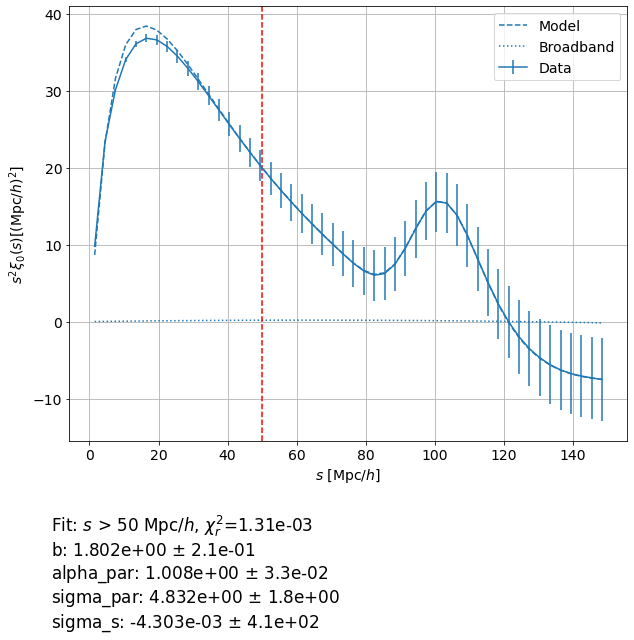

In [11]:
pk_model.plot_model(plot_data=True, show_info=True, show_broadband=True)

### Plot reduced $\chi^2$ as a function of $\alpha$

In [12]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
default_params = {'f': 0., 'b': 1.8, 'alpha_par': 1., 'alpha_perp': 1., 'sigma_par': 5., 'sigma_perp': 5., 'sigma_s': 4.}
pk_model.set_default_params(**default_params)

In [17]:
alphas = np.linspace(0.8, 1.2, 100)
pk_model.set_s_lower_limit(50)

def compute_chi2(alpha):
    pk_model.set_default_params(alpha_par=alpha)
    return pk_model.chi_square(reduced=True)

chi2 = np.array([compute_chi2(alpha) for alpha in alphas])

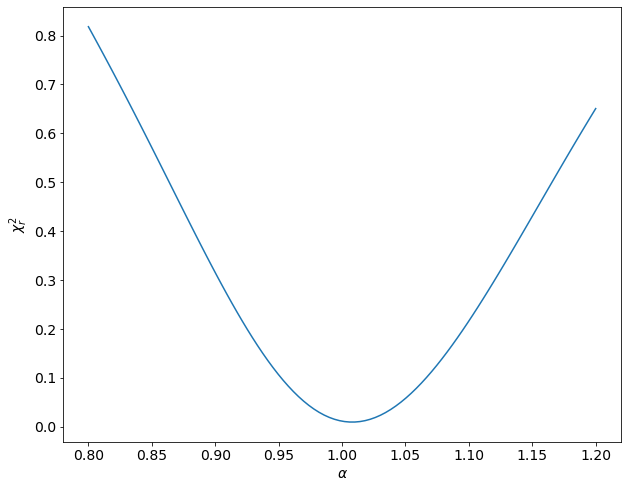

In [20]:
plt.plot(alphas, chi2)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\chi^2_{r}$')
plt.show()